In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install qutip numpy scipy scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.4/32.4 MB 46.8 MB/s eta 0:00:00


Dataset: 200 points in 8D (normalized for quantum encoding)
Classical eigensolve...
Dataset: 200 points in 8D (normalized for quantum encoding)
Enhanced VQGE with shifted Hamiltonian (non-commuting case)...
Finding eigenvalues via tau-scanning (non-commuting case)...
  Eigenpair 1: λ ≈ 0.014499
  Eigenpair 2: λ ≈ 0.035231


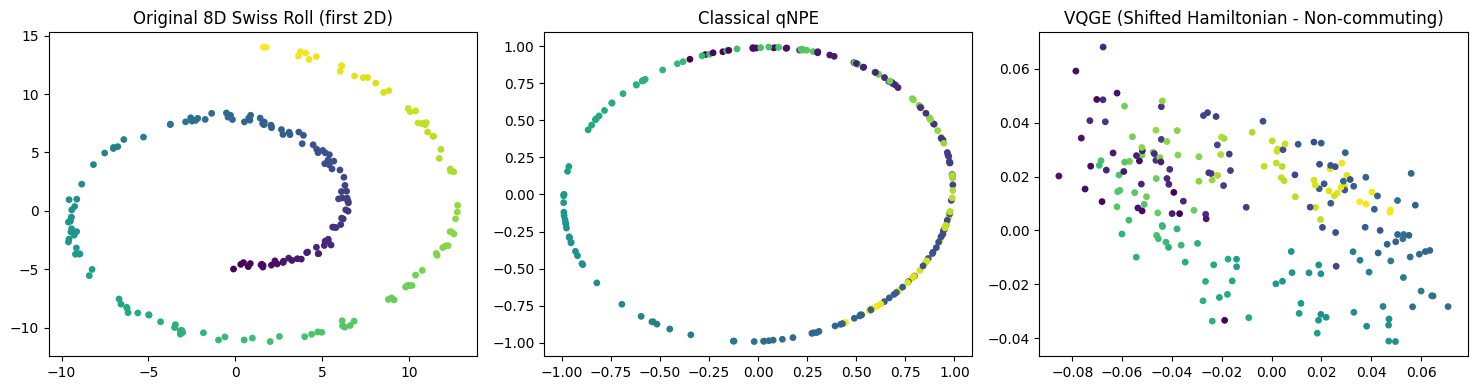

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import solve, eigh, qr
from scipy.optimize import minimize
from sklearn.datasets import make_swiss_roll
import warnings
warnings.filterwarnings("ignore")

# --------------------------------------------------------------
# 1. K-NN + WEIGHTS (unchanged)
# --------------------------------------------------------------
def knn_weights(X, K, reg=1e-6):
    M, D = X.shape
    W = np.zeros((M, M))
    dists = squareform(pdist(X, 'sqeuclidean'))

    for i in range(M):
        cand = np.argpartition(dists[i], K + 1)[1:K + 1]
        neigh_idx = cand[dists[i, cand] > 1e-12]
        if neigh_idx.size == 0:
            continue

        Xi = np.tile(X[i], (neigh_idx.size, 1))
        Xn = X[neigh_idx]
        diffs = Xi - Xn
        G = diffs @ diffs.T + reg * np.eye(neigh_idx.size)
        ones = np.ones(neigh_idx.size)
        w_local = solve(G, ones, assume_a='pos')
        w_local /= w_local.sum()
        W[i, neigh_idx] = w_local
    return W

# --------------------------------------------------------------
# 2. BUILD MATRICES (unchanged)
# --------------------------------------------------------------
def build_matrices(X, W):
    M = X.shape[0]
    I = np.eye(M)
    Q = (I - W).T @ (I - W)
    XXt = X.T @ X
    XQX = X.T @ Q @ X
    return XQX, XXt

# --------------------------------------------------------------
# 3. ENHANCED VQGE WITH PROPER INITIALIZATION AND REGULARIZATION
# --------------------------------------------------------------
class VQGE_Enhanced:
    def __init__(self, G, S, n_qubits=None, layers=3):
        self.G = np.array(G)
        self.S = np.array(S)
        self.D = G.shape[0]
        # Pad to nearest power of 2 for amplitude encoding
        if n_qubits is None:
            self.n = int(np.ceil(np.log2(self.D)))
        else:
            self.n = n_qubits
        self.full_dim = 2 ** self.n
        # Pad G and S with zeros
        if self.full_dim > self.D:
            pad = self.full_dim - self.D
            self.G_padded = np.pad(self.G, ((0, pad), (0, pad)), mode='constant')
            self.S_padded = np.pad(self.S, ((0, pad), (0, pad)), mode='constant')
        else:
            self.G_padded = self.G
            self.S_padded = self.S

        self.layers = layers
        self.n_params = 2 * self.n * layers
        self.found_vecs = []

        # Regularize S to improve conditioning
        self.S_padded_reg = self.S_padded + 1e-8 * np.eye(self.full_dim)

    def ansatz_state(self, params):
        """Hardware-efficient ansatz with entanglement (RY + CZ)"""
        state = np.zeros(self.full_dim)
        state[0] = 1.0

        param_idx = 0
        for layer in range(self.layers):
            # Single-qubit rotations
            for i in range(self.n):
                theta = params[param_idx]
                state = self.apply_ry(state, i, theta)
                param_idx += 1

            # Entangling gates (CZ on adjacent qubits)
            for i in range(self.n - 1):
                state = self.apply_cz(state, i, i+1)

        return state

    def apply_ry(self, state, qubit, theta):
        """Apply RY rotation on qubit 'qubit'"""
        c, s = np.cos(theta/2), np.sin(theta/2)
        new_state = np.zeros_like(state)
        for j in range(len(state)):
            bit = (j >> qubit) & 1
            j_other = j ^ (1 << qubit)
            if bit == 0:
                new_state[j] += c * state[j] - s * state[j_other]
                new_state[j_other] += s * state[j] + c * state[j_other]
        return new_state

    def apply_cz(self, state, control, target):
        """Apply CZ gate between control and target qubits"""
        new_state = np.zeros_like(state)
        for j in range(len(state)):
            ctrl_bit = (j >> control) & 1
            targ_bit = (j >> target) & 1
            if ctrl_bit == 1 and targ_bit == 1:
                new_state[j] = -state[j]
            else:
                new_state[j] = state[j]
        return new_state

    def cost_noncommuting(self, params, tau):
        """Cost function for non-commuting case: [(G - tau*S)/S]^2"""
        psi = self.ansatz_state(params)
        norm = np.linalg.norm(psi)
        if norm < 1e-8:
            return 1e12
        psi = psi / norm

        # Compute expectation values
        eG = psi @ self.G_padded @ psi
        eS = psi @ self.S_padded_reg @ psi  # Use regularized S
        if abs(eS) < 1e-12:
            return 1e12

        # Non-commuting case: minimize [(G - tau*S)/S]^2
        numerator = (eG - tau * eS) ** 2
        denominator = eS ** 2
        return numerator / denominator

    def find_eigenvalue_by_scanning(self, tau_min, tau_max, num_points=500):
        """Find eigenvalues by scanning tau and minimizing cost"""
        taus = np.linspace(tau_min, tau_max, num_points)
        costs = []
        best_params_list = []

        for tau in taus:
            best_cost = 1e12
            best_params = None
            for _ in range(5):  # Multiple random starts
                p0 = np.random.uniform(0, 2*np.pi, self.n_params)
                res = minimize(lambda p: self.cost_noncommuting(p, tau), p0,
                               method='L-BFGS-B', options={'maxiter': 500})
                if res.fun < best_cost:
                    best_cost = res.fun
                    best_params = res.x
            costs.append(best_cost)
            best_params_list.append(best_params)

        # Find local minima in cost curve
        costs = np.array(costs)
        from scipy.signal import argrelextrema
        minima_indices = argrelextrema(costs, np.less, order=5)[0]

        if len(minima_indices) == 0:
            # Fallback: take the global minimum
            minima_indices = [np.argmin(costs)]

        eigenvalues = taus[minima_indices]
        eigenparams = [best_params_list[i] for i in minima_indices]

        # Sort by eigenvalue
        sorted_idx = np.argsort(eigenvalues)
        eigenvalues = eigenvalues[sorted_idx]
        eigenparams = [eigenparams[i] for i in sorted_idx]

        return eigenvalues, eigenparams

    def get_eigenvector_from_params(self, params):
        """Get the normalized eigenvector corresponding to parameters"""
        psi = self.ansatz_state(params)
        norm = np.linalg.norm(psi)
        if norm < 1e-8:
            return None
        psi = psi / norm
        # Truncate back to original dimension
        vec_orig = psi[:self.D]
        return vec_orig

    def find_all_eigenpairs(self, d=2, tau_range_factor=2.0):
        """Main method to find d smallest eigenpairs using shifting"""
        print("Finding eigenvalues via tau-scanning (non-commuting case)...")
        # Estimate rough bounds for tau using classical solver
        vals, vecs = eigh(self.G, self.S)
        lambda_min, lambda_max = vals[0], vals[-1]
        # Expand the range slightly
        tau_min = lambda_min - tau_range_factor * abs(lambda_min)
        tau_max = lambda_max + tau_range_factor * abs(lambda_max)

        # Scan to find all eigenvalues
        eigenvals, eigenparams = self.find_eigenvalue_by_scanning(tau_min, tau_max)

        # Extract d smallest eigenpairs
        A = []
        for i in range(min(d, len(eigenvals))):
            val = eigenvals[i]
            params = eigenparams[i]
            vec = self.get_eigenvector_from_params(params)
            if vec is not None:
                A.append(vec)
                print(f"  Eigenpair {i+1}: λ ≈ {val:.6f}")
            else:
                print(f"  Failed to get vector for λ={val:.6f}")

        if len(A) < d:
            print(f"Warning: Only found {len(A)} eigenpairs, padding with zeros.")
            while len(A) < d:
                A.append(np.zeros(self.D))

        A = np.stack(A, axis=1)
        return A

# --------------------------------------------------------------
# 4. FULL qNPE PIPELINE (with fixes)
# --------------------------------------------------------------
def qnpe_fixed(X, K, d=2, use_vqge=False, n_qubits=5):
    # Normalize for amplitude encoding (paper assumption)
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms[norms == 0] = 1
    X_norm = X / norms

    print(f"Dataset: {X_norm.shape[0]} points in {X_norm.shape[1]}D (normalized for quantum encoding)")
    W = knn_weights(X_norm, K)
    XQX, XXt = build_matrices(X_norm, W)

    if not use_vqge:
        print("Classical eigensolve...")
        vals, vecs = eigh(XQX, XXt)
        idx = np.argsort(vals)[:d]
        A = vecs[:, idx]
    else:
        print("Enhanced VQGE with shifted Hamiltonian (non-commuting case)...")
        vqge = VQGE_Enhanced(XQX, XXt, n_qubits=n_qubits, layers=3)
        A = vqge.find_all_eigenpairs(d=d)

    # Normalize columns of A
    A = A / np.linalg.norm(A, axis=0, keepdims=True)
    Y = X_norm @ A
    return Y, A

# --------------------------------------------------------------
# --------------------------------------------------------------
# 5. DEMO - Use a Higher-Dimensional Dataset
# --------------------------------------------------------------
# Generate a higher-dimensional Swiss Roll (e.g., 8D)
from sklearn.datasets import make_swiss_roll
import numpy as np

# Create a higher-dimensional Swiss Roll
n_samples = 200
noise = 0.2
random_state = 42

# Generate 8D data where the first 2 dimensions form the Swiss Roll
X_2d, color = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=random_state)

# Pad to 8D by adding random noise or zeros to other dimensions
D_target = 8
X = np.zeros((n_samples, D_target))
X[:, :2] = X_2d[:, [0, 2]]  # Use x and z from Swiss Roll
# Add some random noise to other dimensions to make it truly 8D
np.random.seed(random_state)
X[:, 2:] = np.random.normal(0, 0.1, size=(n_samples, D_target - 2))

K = 8
d = 2  # Target dimension for embedding

# Classical baseline
Y_classic, A_classic = qnpe_fixed(X, K=K, d=d, use_vqge=False)

# Enhanced VQGE
Y_vqge, A_vqge = qnpe_fixed(X, K=K, d=d, use_vqge=True)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].scatter(X[:, 0], X[:, 1], c=color, s=15, cmap='viridis')
axs[0].set_title("Original 8D Swiss Roll (first 2D)")
axs[1].scatter(Y_classic[:, 0], Y_classic[:, 1], c=color, s=15, cmap='viridis')
axs[1].set_title("Classical qNPE")
axs[2].scatter(Y_vqge[:, 0], Y_vqge[:, 1], c=color, s=15, cmap='viridis')
axs[2].set_title("VQGE (Shifted Hamiltonian - Non-commuting)")
plt.tight_layout()
plt.show()